In [8]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import itertools
import re
import time
import math
import json

from collections import Counter

sns.set(style="white", color_codes=True,font_scale=1)
%matplotlib inline

In [9]:
def sec_to_min(seconds) :
    minutes = int(seconds/60)
    secs = seconds%60
    if secs == 0 :
        return '%d\'' % minutes
    else :
        return '%02d:%02d' % (minutes, secs)

In [10]:
def time_to_slot(seconds) :
    return math.floor(seconds/5)

For this video, we define the following slide changes :

In [11]:
slide_change = [-1,23,98,173,336,632,698,786,860,1099,1147]
slide_change_slots = [time_to_slot(x) for x in slide_change]

In [73]:
df_views = pd.read_csv('Video_6_4/EPFLx-BIO465x-2013_OND___66fc2e3957e342a3b8bd844a8852d581.csv')
df_views['num_replays'] = df_views['num_views'] - df_views['num_users']
df_views['ratio_replays'] = df_views['num_replays'] / df_views['num_views']*50
df_views.head(5)

,created,num_users,num_views,segment,num_replays,ratio_replays
0,2017-02-28T071027,49,78,0,29,18.589744
1,2017-02-28T071027,46,65,1,19,14.615385
2,2017-02-28T071027,45,64,2,19,14.843750
3,2017-02-28T071027,44,60,3,16,13.333333
4,2017-02-28T071027,44,61,4,17,13.934426


In [13]:
df_slides = pd.read_csv('Video_6_4/video_6_4.csv')
df_slides.head(10)

,0,1
0,4.0,2
1,4.0,3
2,51.0,4
3,4.0,5
4,0.0,6
5,0.0,7
6,0.0,8
7,0.0,9
8,0.0,10
9,0.0,11


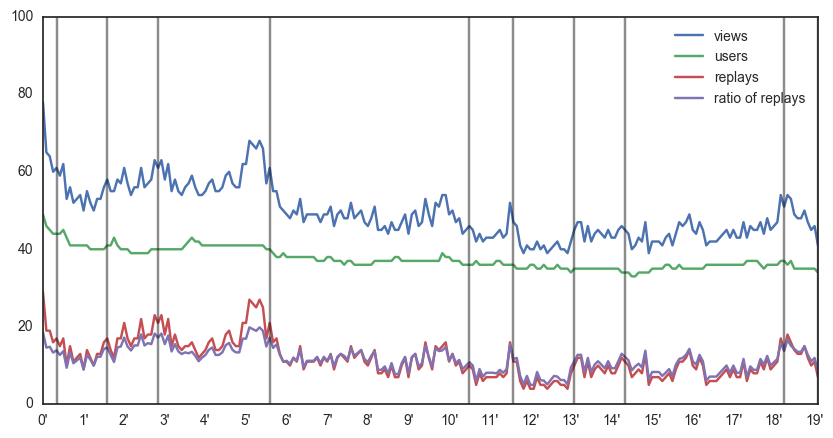

In [74]:
fig = plt.figure(figsize=(10,5))
plt.plot(df_views['num_views'], label='views')
plt.plot(df_views['num_users'], label='users')
plt.plot(df_views['num_replays'], label='replays')
plt.plot(df_views['ratio_replays'], label='ratio of replays')
for x in slide_change_slots :
    plt.plot((x, x), (0, 100), 'k-', alpha=0.5)
plt.ylim([0,100])
plt.xlim([0,len(df_views)-1])
plt.xticks(range(0,len(df_views)-1,12), [sec_to_min(5*x) for x in range(0,len(df_views)-1,12)], rotation=-0);
plt.legend();

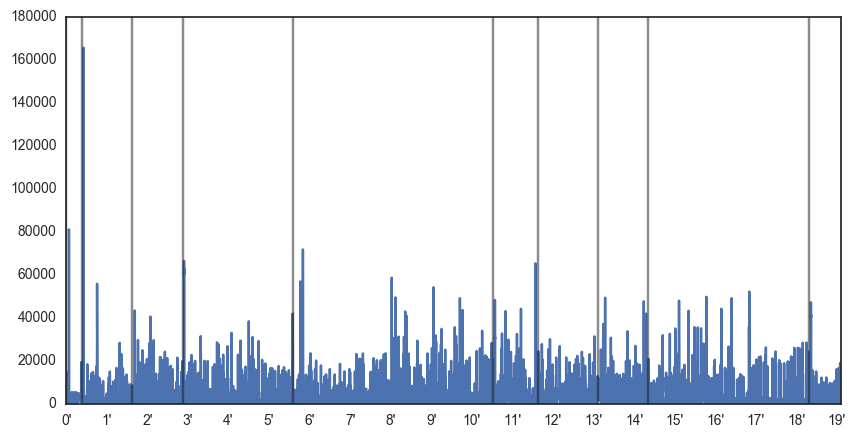

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(df_slides['0'])
for x in slide_change :
    plt.plot((x*25, x*25), (0, 180000), 'k-', alpha=0.5)
plt.xlim([0,len(df_slides)-1])
plt.xticks(range(0,len(df_slides)-1,1500), [sec_to_min(x/25) for x in range(0,len(df_slides)-1,1500)], rotation=-0);

In [51]:
df_click_views = pd.read_csv('Video_6_4/66fc2e3957e342a3b8bd844a8852d581.csv')
df_click_views.drop(['DataPackageID','SessionUserID','EventType','VideoID','CurrentTime',
                     'SeekType','NewSpeed','YEAR(from_unixtime(TimeStamp))'], axis=1, inplace=True)

df_click_views['oldtime_slots'] = pd.cut(df_click_views['OldTime'], slide_change,
                                         labels=[x for x in range(0,len(slide_change)-1)])
df_click_views['newtime_slots'] = pd.cut(df_click_views['NewTime'], slide_change,
                                         labels=[x for x in range(0,len(slide_change)-1)])
df_click_views['TimeDiff'] = df_click_views['NewTime'] - df_click_views['OldTime']
df_click_views['SameSlot'] = df_click_views.apply(lambda row : 1 if row['oldtime_slots'] ==
                                                  row['newtime_slots'] else 0,axis=1)

df_click_views.to_csv('Video_6_4/temp.csv')
df_click_views = pd.read_csv('Video_6_4/temp.csv')
df_click_views.drop(['Unnamed: 0'], axis=1, inplace=True)
df_click_views['SlotDiff'] = df_click_views['newtime_slots'] - df_click_views['oldtime_slots']


print('Percentage of jumps inside the same slot : ',
      int(len(df_click_views[df_click_views['SameSlot'] == 1])/len(df_click_views)*10000)/100, '%')
df_click_views = df_click_views[df_click_views['TimeDiff'] != 0].copy()
print('Percentage of jumps inside the same slot (cleaned) : ',
      int(len(df_click_views[df_click_views['SameSlot'] 
                                     == 1])/len(df_click_views)*10000)/100, '%')
df_click_views['old_slots'] = df_click_views['oldtime_slots'].apply(lambda x : 'source ' + str(x))
df_click_views['new_slots'] = df_click_views['newtime_slots'].apply(lambda x : 'target ' + str(x))
df_click_views.head(10)

Percentage of jumps inside the same slot :  73.83 %
Percentage of jumps inside the same slot (cleaned) :  71.93 %


,AccountUserID,TimeStamp,OldTime,NewTime,oldtime_slots,newtime_slots,TimeDiff,SameSlot,SlotDiff,old_slots,new_slots
0,807336,1389880021,918.370,1117,8,9,198.630,0,1,source 8,target 9
1,2770982,1390821303,299.000,300,3,3,1.000,1,0,source 3,target 3
2,2382155,1386790840,174.000,171,3,2,-3.000,0,-1,source 3,target 2
3,2102927,1387402052,781.000,820,6,7,39.000,0,1,source 6,target 7
4,2017599,1412624441,313.913,345,3,4,31.087,0,1,source 3,target 4
5,2690937,1387111637,125.319,124,2,2,-1.319,1,0,source 2,target 2
6,603079,1386115991,1082.000,1083,8,8,1.000,1,0,source 8,target 8
7,138131,1386782480,213.000,251,3,3,38.000,1,0,source 3,target 3
8,2695484,1388343411,102.000,155,2,2,53.000,1,0,source 2,target 2
9,2663465,1386790238,329.733,329,3,3,-0.733,1,0,source 3,target 3


In [52]:
df_click_views_jump = df_click_views[df_click_views['oldtime_slots'] != df_click_views['newtime_slots']]

In [53]:
df_clean_to_d3 = df_click_views_jump.groupby(['old_slots','new_slots']).agg({'AccountUserID' : 'count'}).copy()
df_clean_to_d3 = df_clean_to_d3.reset_index().rename(index=str, columns={'old_slots': 'source', 'new_slots': 'target', 'AccountUserID' : 'value'})
df_clean_to_d3.head(5)

,source,target,value
0,source 0,target 1,71
1,source 0,target 2,28
2,source 0,target 3,17
3,source 0,target 4,27
4,source 0,target 5,9


,SlotDiff,AccountUserID
0,-8,2
1,-5,2
2,-4,18
3,-3,8
4,-2,33
5,-1,819
6,1,619
7,2,65
8,3,29
9,4,31


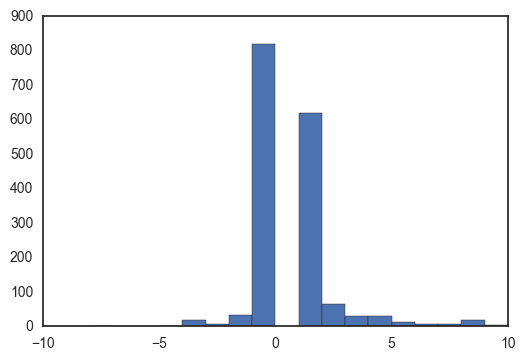

In [93]:
aa = df_click_views_jump.groupby(['SlotDiff']).agg({'AccountUserID' : 'count'}).reset_index()
plt.bar(aa['SlotDiff'], aa['AccountUserID'], width=1)
plt.xlim([-10,10])
aa

In [54]:
df_to_d3 = df_click_views.groupby(['old_slots','new_slots']).agg({'AccountUserID' : 'count'}).copy()
df_to_d3 = df_to_d3.reset_index().rename(index=str, columns={'old_slots': 'source', 'new_slots': 'target', 'AccountUserID' : 'value'})
df_to_d3.head(5)

,source,target,value
0,source 0,target 0,60
1,source 0,target 1,71
2,source 0,target 2,28
3,source 0,target 3,17
4,source 0,target 4,27


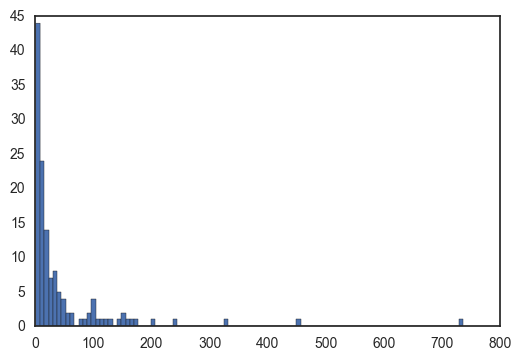

In [55]:
user_dict = Counter(df_click_views['AccountUserID'].values).values()
user_dict
plt.hist(list(user_dict), bins=100);

In [83]:
flare = dict()
flare = {"links" : [], "nodes":[]}


for line in df_to_d3.values:
    source = line[0]
    source_n = source[7]
    target = line[1]
    target_n = target[7]
    value = line[2]
    
    if source_n > target_n :
        color = "#C0C0C0"
    elif source_n < target_n :
        color = "#C0C0C0"
    else :
        color = "#C0C0C0"
    
    if {"name" : source} not in flare["nodes"] :
        flare["nodes"].append({"name" : source})
    if {"name" : target} not in flare["nodes"] :
        flare["nodes"].append({"name" : target})

    flare["links"].append({"source": source, "target": target, "value" : str(value), "color" : color})


with open('d3/test1.json', 'w') as outfile:
    json.dump(flare, outfile)

In [81]:
flare = dict()
flare = {"links" : [], "nodes":[]}


for line in df_clean_to_d3.values:
    source = line[0]
    source_n = source[7]
    target = line[1]
    target_n = target[7]
    value = line[2]
    
    if source_n > target_n :
        color = "#C0C0C0"
    elif source_n < target_n :
        color = "#C0C0C0"
    else :
        color = "yellow"
    
    if {"name" : source} not in flare["nodes"] :
        flare["nodes"].append({"name" : source})
    if {"name" : target} not in flare["nodes"] :
        flare["nodes"].append({"name" : target})

    flare["links"].append({"source": source, "target": target, "value" : str(value), "color" : color})

with open('d3/test2.json', 'w') as outfile:
    json.dump(flare, outfile)

Percentage of jumps back in time :  59.63 %
Percentage of jumps constant in time :  0.0 %
Percentage of jumps forward in time :  40.36 %


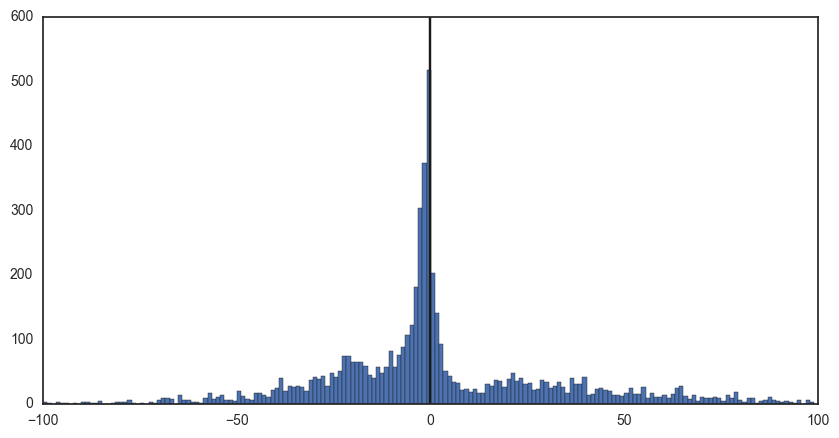

In [24]:
user_dict = df_click_views['TimeDiff'].values
user_dict
fig = plt.figure(figsize=(10,5))
aa = plt.hist(list(user_dict), bins=2000);
plt.plot((0, 0), (0, 600), 'k-', alpha=1)
plt.xlim([-100,100]);
print('Percentage of jumps back in time : ',
      int(len(df_click_views[df_click_views['TimeDiff'] < 0])/len(df_click_views)*10000)/100, '%')
print('Percentage of jumps constant in time : ',
      int(len(df_click_views[df_click_views['TimeDiff'] == 0])/len(df_click_views)*10000)/100, '%')
print('Percentage of jumps forward in time : ',
      int(len(df_click_views[df_click_views['TimeDiff'] > 0])/len(df_click_views)*10000)/100, '%')